In [ ]:
# happen with one hot encoded labels,
# or labels with more than two unique values
# where we cant use sigmoid(explained later).

In [6]:
# we need to interpret outputs as probabilities
# to be able to use the maximumlikelihood correctly.
# so the labels must be a range of probabilites that sum up to one.

# O = XW + b
# Y' = softmax(O)
# imagine having three outputs = yi=1, yj=8, yk=1
# softmax(j) = e^j / sum(e^m for m-class in classes)
# but for high number exp(n) gives an overflow error which will be fixed later.

import math
prob = (math.exp(8)) / ((math.exp(1) + math.exp(8) + math.exp(1)))
print(prob)

0.9981795561287619


In [ ]:
# loglikelihood
# we take the softmax probs as conditional probabilities to the class.
# P(Y | X) = prod(P(Y(i) | X(i))) for all samples must be maximized.
# which is equal to minizing the negative loglikelihood

In [ ]:
!pip install mxnet gluoncv

In [8]:
import mxnet as mx
from mxnet import gluon
import sys

In [10]:
mnist_train = gluon.data.vision.FashionMNIST(train=True)
mnist_test = gluon.data.vision.FashionMNIST(train=False)

In [ ]:
len(mnist_train), len(mnist_test)

In [11]:
mnist_train[0][0].shape

(28, 28, 1)

In [12]:
def get_fashion_mnist_labels(labels):
  """Return text labels for the Fashion-MNIST dataset."""
  text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [text_labels[int(i)] for i in labels]

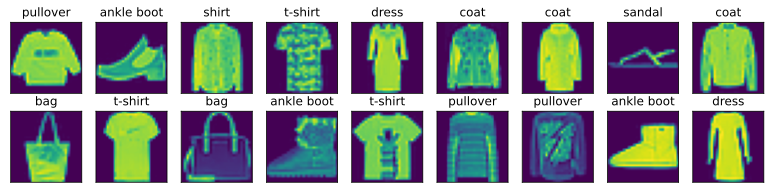

In [71]:
X, y = mnist_train[:18]
d2l.show_images(X.squeeze(axis=-1), 2, 9, titles=get_fashion_mnist_labels(y));

In [22]:
batch_size = 256
def get_dataloader_workers(): #@save
  """Use 4 processes to read the data except for Windows."""
  return 0 if sys.platform.startswith('win') else 4
# `ToTensor` converts the image data from uint8 to 32-bit floating point. It
# divides all numbers by 255 so that all pixel values are between 0 and 1
transformer = gluon.data.vision.transforms.ToTensor()

In [23]:
train_iter = gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                  batch_size, shuffle=True,
                                  num_workers=get_dataloader_workers())

In [24]:
for X, y in train_iter:
  continue


In [36]:
def load_data_fashion_mnist(batch_size, resize=None): #@save
  """Download the Fashion-MNIST dataset and then load it into memory."""
  dataset = gluon.data.vision
  trans = [dataset.transforms.ToTensor()]
  if resize:
    trans.insert(0, dataset.transforms.Resize(resize))
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
            num_workers=get_dataloader_workers()),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
            num_workers=get_dataloader_workers()))

In [31]:
import mxnet as mx
from mxnet import autograd, np, npx, gluon
from IPython import display
npx.set_np()

In [34]:
train_iter, test_iter = load_data_fashion_mnist(batch_size=256, resize=28)
for X, y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

(256, 1, 28, 28) float32 (256,) int32


In [35]:
num_inputs = 784
num_outputs = 10
W = np.random.normal(0, 0.01, (num_inputs, num_outputs))
b = np.zeros(num_outputs)
W.attach_grad()
b.attach_grad()

In [37]:
def softmax(X):
  X_exp = np.exp(X)
  partition = X_exp.sum(1, keepdims=True)
  return X_exp / partition # The broadcasting mechanism is applied here

In [39]:
X = np.random.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(array([[0.03987857, 0.11318518, 0.7515149 , 0.05120853, 0.04421281],
        [0.11961216, 0.5534255 , 0.0496603 , 0.200327  , 0.07697506]]),
 array([1., 1.]))

In [40]:
def net(X):
  return softmax(np.dot(X.reshape((-1, W.shape[0])), W) + b)

In [41]:
y = np.array([0, 2])
y_hat = np.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

array([0.1, 0.5])

In [42]:
def cross_entropy(y_hat, y):
  return - np.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)

array([2.3025851, 0.6931472])

In [44]:
# assuming that the first label was zero, so we calculate the crossentropy looking at that prob.
# which turns out to be quite high.
# for the second sample the label was 2. which is indeed correct and the loss is less.
# but still is not that low due to uncertainty.
print(y_hat)
print(y)
print(y_hat[range(len(y_hat)), y])

[[0.1 0.3 0.6]
 [0.3 0.2 0.5]]
[0. 2.]
[0.1 0.5]


In [49]:
print(-np.log(0.1, 0.))
print(-np.log(0.5, 2.))
print(-np.log(1., 2.))

2.3025850929940455
0.6931471805599453
-0.0


In [54]:
def accuracy(y_hat, y): #@save
  """Compute the number of correct predictions."""
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
  cmp = y_hat.astype(y.dtype) == y
  return float(np.sum(cmp.astype(y.dtype)))

In [55]:
accuracy(y_hat, y) / len(y)

0.5

In [57]:
class Accumulator: #@save
  """For accumulating sums over `n` variables."""
  def __init__(self, n):
    self.data = [0.0] * n
  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)]
  def reset(self):
    self.data = [0.0] * len(self.data)
  def __getitem__(self, idx):
    return self.data[idx]

In [59]:
def evaluate_accuracy(net, data_iter): #@save
  """Compute the accuracy for a model on a dataset."""
  metric = Accumulator(2) # No. of correct predictions, no. of predictions
  for _, (X, y) in enumerate(data_iter):
    metric.add(accuracy(net(X), y), y.size)
  return metric[0] / metric[1]

In [61]:
evaluate_accuracy(net, test_iter)

0.0975

In [62]:
def train_epoch_ch3(net, train_iter, loss, updater): #@save
  """Train a model within one epoch (defined in Chapter 3)."""
  # Sum of training loss, sum of training accuracy, no. of examples
  metric = Accumulator(3)
  if isinstance(updater, gluon.Trainer):
    updater = updater.step
  for X, y in train_iter:
  # Compute gradients and update parameters
    with autograd.record():
      y_hat = net(X)
      l = loss(y_hat, y)
    l.backward()
    updater(X.shape[0])
    metric.add(float(l.sum()), accuracy(y_hat, y), y.size)
  # Return training loss and training accuracy
  return metric[0] / metric[2], metric[1] / metric[2]

In [63]:
!pip install d2l

In [64]:
from d2l import mxnet as d2l

In [65]:
class Animator: #@save
  """For plotting data in animation."""
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
              ylim=None, xscale='linear', yscale='linear',
              fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
              figsize=(3.5, 2.5)):
    # Incrementally plot multiple lines
    if legend is None:
      legend = []
    d2l.use_svg_display()
    self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    # Use a lambda function to capture arguments
    self.config_axes = lambda: d2l.set_axes(
      self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts

  def add(self, x, y):
    # Add multiple data points into the figure
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x, "__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a, b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    self.config_axes()
    display.display(self.fig)
    display.clear_output(wait=True)

In [68]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
  """Train a model (defined in Chapter 3)."""
  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                      legend=['train loss', 'train acc', 'test acc'])
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc,))
  train_loss, train_acc = train_metrics
  assert train_loss < 0.5, train_loss
  assert train_acc <= 1 and train_acc > 0.7, train_acc
  assert test_acc <= 1 and test_acc > 0.7, test_acc

In [66]:
lr = 0.1
def updater(batch_size):
  return d2l.sgd([W, b], lr, batch_size)

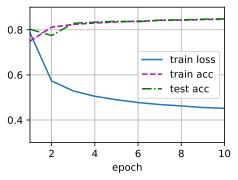

In [69]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

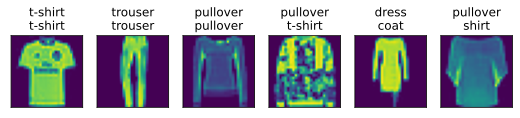

In [70]:
def predict_ch3(net, test_iter, n=6): #@save
  """Predict labels (defined in Chapter 3)."""
  for X, y in test_iter:
    break
  trues = d2l.get_fashion_mnist_labels(y)
  preds = d2l.get_fashion_mnist_labels(d2l.argmax(net(X), axis=1))
  titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
  d2l.show_images(d2l.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])
predict_ch3(net, test_iter)